In [21]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
#matplotlib inline

url="http://commondatastorage.googleapis.com/books1000/"
last_percent_reported=None

def downloadProgressHook(count, blockSize, totalSize):
	global last_percent_reported
	percent = int(count * blockSize * 100 / totalSize)

	if last_percent_reported != percent:
		if percent % 5 == 0:
			sys.stdout.write("%s%%" %percent)
			sys.stdout.flush()
		else:
			sys.stdout.write(".")
			sys.stdout.flush()

		last_percent_reported = percent


def maybeDownload(filename, expectedBytes, force=False):
	if force or not os.path.exists(filename):
		print('Attempting to download', filename)
		filename, _ = urlretrieve(url + filename, filename, reporthook=downloadProgressHook)
		print('\nDownload Complete')
	statinfo = os.stat(filename)
	if statinfo.st_size == expectedBytes:
		print('Found and verified', filename)
	else:
		raise Exception(
			'Failed to verify' + filename + '. Can you get to it with a browser?')
	return filename

trainFilename = maybeDownload('notMNIST_large.tar.gz', 247336696)
testFilename = maybeDownload('notMNIST_small.tar.gz', 8458043)




numClasses = 10
np.random.seed(133)

def maybeExtract(filename, force=False):
	#root = notMNIST_small or _large, just split the suffix
	root = os.path.splitext(os.path.splitext(filename)[0])[0]
	if os.path.isdir(root) and not force:
		print('%s already present - Skipping extraction of %s.' %(root, filename))
	else:
		print('Extracting data for %s. This may take a while. Please wait.' %root)
		tar = tarfile.open(filename)
		sys.stdout.flush()
		tar.extractall()
		tar.close()
	dataFolders = [os.path.join(root,d) for d in sorted(os.listdir(root)) 
		if os.path.isdir(os.path.join(root,d))]

	if len(dataFolders) != numClasses:
		raise Exception(
			'Expected %d folders, one per class. Found %d instead.' %(numClasses, len(dataFolders)))
	print(dataFolders)
	return dataFolders

trainFolders = maybeExtract(trainFilename)
testFolders = maybeExtract(testFilename)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz
notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [2]:
display(Image(filename="notMNIST_small/B/MDEtMDEtMDAudHRm.png"))

In [3]:
tempPath = 'notMNIST_small/E'
tempAbsPath = os.listdir(tempPath)[1]
display(Image(filename=tempPath+'/'+tempAbsPath))
print(tempAbsPath)

QmV0YSBCbG9jay50dGY=.png


In [4]:
imageSize = 28
pixelDepth = 255.0

def loadLetter(folder, minNumImages):
	imageFiles = os.listdir(folder)

	#setup each image is one element of np array
	dataset = np.ndarray(shape=(len(imageFiles), imageSize, imageSize), dtype=np.float32)

	print(folder)
	numImages = 0
	for image in imageFiles:
		imageFile = os.path.join(folder,image)
		try:
			imageData = (ndimage.imread(imageFile).astype(float) - pixelDepth/2 ) /pixelDepth
			if imageData.shape != (imageSize, imageSize):
				raise Exception('Unexpected image shape: %s' % str(imageData.shape))

			dataset[numImages, :, :] = imageData
			numImages += 1
		except IOError as e:
			print('Could not read:', imageFile, ':', e, '- it\'s ok, skipping.')


	dataset = dataset[0:numImages, :, :]

	if numImages < minNumImages:
		raise Exception('Many fewer images than expected: %d < %d' %(numImages, minNumImages))

	print('Full dataset tensor:', dataset.shape)
	print('Mean:', np.mean(dataset))
	print('Standard deviation:', np.std(dataset))
	return dataset


def maybePickle(dataFolders, minNumImagesPerClass, force=False):
	datasetNames = []
	for folder in dataFolders:
		setFileName = folder + '.pickle'
		datasetNames.append(setFileName)
		if os.path.exists(setFileName) and not force:
			print('%s already present - Skipping pickling.' %setFileName)
		else:
			print('Pickling %s.'% setFileName)	
			dataset = loadLetter(folder, minNumImagesPerClass)
			try:
				with open(setFileName, 'wb') as f:
					pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
			except Exception as e:
				print('Unable to save data to', setFileName, ':', e)
	return datasetNames

trainDatasets = maybePickle(trainFolders, 45000)
testDatasets = maybePickle(testFolders, 1800)


notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [5]:

labelLetter = 'ABCDEFGHIJ'
for i in range(10):
	with open(trainDatasets[i],'rb') as f:
		letterSet = pickle.load(f)
	print('Size of data set for class ' + labelLetter[i] + ': '+str(len(letterSet)))


Size of data set for class A: 52909
Size of data set for class B: 52911
Size of data set for class C: 52912
Size of data set for class D: 52911
Size of data set for class E: 52912
Size of data set for class F: 52912
Size of data set for class G: 52912
Size of data set for class H: 52912
Size of data set for class I: 52912
Size of data set for class J: 52911


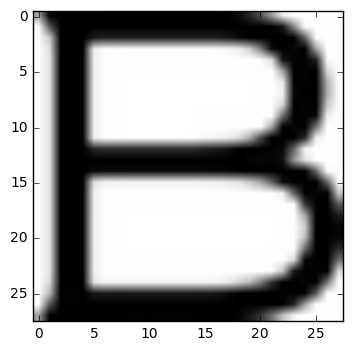

In [6]:
%matplotlib inline
pickleFile = trainDatasets[np.random.randint(len(trainDatasets))]
#pickleFile = trainDatasets[0]
with open (pickleFile, 'rb') as f:
	letterSet = pickle.load(f)
	sampleIdx = np.random.randint(len(letterSet))
	sampleImage = letterSet[sampleIdx, :, :]
	plt.figure()
	plt.imshow(sampleImage,cmap='Greys')

In [7]:
def makeArrays(nbRows, imgSize):
	if nbRows:
		dataset = np.ndarray((nbRows, imgSize, imgSize),dtype=np.float32)
		labels = np.ndarray(nbRows, dtype=np.int32)
	else:
		dataset, labels = None, None
	return dataset,labels

def mergeDatasets(pickleFiles, trainSize, validSize=0):
	numClasses = len(pickleFiles)
	validDataset, validLabels = makeArrays(validSize, imageSize)
	trainDataset, trainLabels = makeArrays(trainSize, imageSize)
	vsizePerClass = validSize//numClasses
	tsizePerClass = trainSize//numClasses

	startV, startT = 0, 0
	endV, endT = vsizePerClass, tsizePerClass
	endL = vsizePerClass + tsizePerClass
	for label, pickleFile in enumerate(pickleFiles):
		try:
			with open(pickleFile, 'rb') as f:
				letterSet = pickle.load(f)
				#shuffle the letters to have random validation and training set
				np.random.shuffle(letterSet)
				if validDataset is not None:
					validLetter = letterSet[:vsizePerClass,:,:]
					validDataset[startV:endV,:,:]=validLetter
					validLabels[startV:endV]=label
					startV += vsizePerClass
					endV += vsizePerClass

				trainLetter = letterSet[vsizePerClass:endL, :,:]
				trainDataset[startT:endT,:,:]=trainLetter
				trainLabels[startT:endT] = label
				startT += tsizePerClass
				endT += tsizePerClass
		except Exception as e:
			print('Unable to process data from', pickleFile, ':',e)
			raise

	return validDataset, validLabels, trainDataset, trainLabels

trainSize = 200000
validSize = 10000
testSize = 10000

validDataset, validLabels, trainDataset, trainLabels=mergeDatasets(trainDatasets, trainSize, validSize) 
_, _, testDataset, testLabels = mergeDatasets(testDatasets,testSize)
print('Training:', trainDataset.shape, trainLabels.shape)
print('Validation', validDataset.shape, validLabels.shape)
print('Testing', testDataset.shape, testLabels.shape)


Training: (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)
Testing (10000, 28, 28) (10000,)


In [8]:
def randomize(dataset, labels):
	permutation = np.random.permutation(labels.shape[0])
	shuffledDataset = dataset[permutation,:,:]
	shuffledLabels = labels[permutation]
	return shuffledDataset, shuffledLabels

trainDataset, trainLabels = randomize(trainDataset,trainLabels)
testDataset, testLabels = randomize(testDataset, testLabels)
validDataset, validLabels = randomize(validDataset, validLabels)


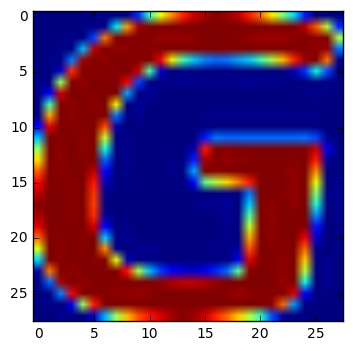

In [9]:
%matplotlib inline
sampleIdx = np.random.randint(len(trainDataset))
sampleImage = trainDataset[sampleIdx, :, :]
plt.figure()
#plt.imshow(sampleImage,cmap='Greys')
plt.imshow(sampleImage)

In [10]:

pickleFile = 'notMNIST.pickle'
try:
	f = open(pickleFile, 'wb')
	save = {
		'trainDataset': trainDataset,
		'trainLabels': trainLabels,
		'validDataset': validDataset,
		'validLabels': validLabels,
		'testDataset': testDataset,
		'testLabels': testLabels,
		}
	pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
	f.close()
except Exception as e:
	print('Unable to save data to', pickleFile, ':', e)
	raise

statinfo = os.stat(pickleFile)
print('Compressed pickle file size:', statinfo.st_size)

Compressed pickle file size: 690800497


In [11]:
from hashlib import md5

# def checkOverlap(dataset1, dataset2):
# 	dataset1.flags.writeable = False
# 	dataset2.flags.writeable = False
# 	noOverlapSet1 = set([md5(x).hexdigest() for x in dataset1]) #no overlap inside the dataset
# 	overLapInside1 = len(dataset1)-len(noOverlapSet1)
# 	noOverlapSet2 = set([md5(x).hexdigest() for x in dataset2]) #no overlap inside the dataset
# 	overLapInside2 = len(dataset2)-len(noOverlapSet2)
# 	overLap = len(set.intersection(noOverlapSet1,noOverlapSet2))

# 	return overLap,overLapInside1, overLapInside2
trainHash=[md5(x).hexdigest() for x in trainDataset]
testHash=[md5(x).hexdigest() for x in testDataset]
validHash=[md5(x).hexdigest() for x in validDataset]

uniqueTrainSet = set(trainHash)
uniqueTestSet = set(testHash)
uniqueValidSet = set(validHash)

overLapInsideTrain = len(trainDataset)-len(uniqueTrainSet)
overLapInsideTest = len(testDataset)-len(uniqueTestSet)
overLapInsideValid = len(validDataset)-len(uniqueValidSet)

overLapBetweenTrainTest = len(set.intersection(uniqueTrainSet,uniqueTestSet))
overLapBetweenTrainValid = len(set.intersection(uniqueTrainSet,uniqueValidSet))
overLapBetweenValidTest = len(set.intersection(uniqueValidSet,uniqueTestSet))


print('the amount of overlap inside trainDataSet is: ', overLapInsideTrain)
print('the amount of overlap inside testDataSet is: ', overLapInsideTest)
print('the amount of overlap inside validDataSet is: ', overLapInsideValid)


print('the amount of overlap between trainDataSet and testDataset is: ', 
	overLapBetweenTrainTest)
print('the amount of overlap between trainDataSet and validDataset is: ', 
	overLapBetweenTrainValid)
print('the amount of overlap between validDataSet and testDataset is: ', 
	overLapBetweenValidTest)


the amount of overlap inside trainDataSet is:  12677
the amount of overlap inside testDataSet is:  194
the amount of overlap inside validDataSet is:  134
the amount of overlap between trainDataSet and testDataset is:  1163
the amount of overlap between trainDataSet and validDataset is:  942
the amount of overlap between validDataSet and testDataset is:  80


In [12]:
#sanitized dataset
#actually the duplicate inside the dataset has little effect on the final result

testInTrain = np.in1d(testHash, trainHash)
validInTrain = np.in1d(validHash, trainHash)
testInValid = np.in1d(testHash, validHash)

validKeep = ~validInTrain
testKeep = ~(testInTrain | testInValid)

testDatasetSanitized = testDataset[testKeep]
testLabelsSanitized = testLabels[testKeep]

validDatasetSanitized = validDataset[validKeep]
validLabelsSanitized = validLabels[validKeep]

In [22]:
#set model
clf = LogisticRegression(penalty='l2', C=1e-1, solver='newton-cg',max_iter=1000,multi_class='multinomial',warm_start=True,n_jobs=-1)

#prepare data
(trainSamples, trainWidth, trainHeight) = trainDataset.shape
transformedTrainDataset = np.reshape(trainDataset,(trainSamples, trainWidth*trainHeight))[0:20000]

(testSamples, testWidth, testHeight) = testDataset.shape
transformedTestDataset = np.reshape(testDataset, (testSamples,testWidth*testHeight))

(testSamplesSanitized, testWidthSanitized, testHeightSanitized) = testDatasetSanitized.shape
transformedTestDatasetSanitized = np.reshape(testDatasetSanitized,(testSamplesSanitized, testWidthSanitized*testHeightSanitized))

clf.fit(transformedTrainDataset,trainLabels[0:20000])

testPred = clf.predict(transformedTestDataset)
testPredSanitized = clf.predict(transformedTestDatasetSanitized)

print('Accuracy Score original data ', accuracy_score(testLabels,testPred),
	'Accuracy Score sanitized data ', accuracy_score(testLabelsSanitized,testPredSanitized))
print('Precision Score original data', precision_score(testLabels,testPred,average='weighted'),
	'Precision Score sanitized data ', precision_score(testLabelsSanitized, testPredSanitized,average='weighted'))
print('Recall Score original data', recall_score(testLabels,testPred,average='weighted'),
	'Recall Score sanitized data ', recall_score(testLabelsSanitized, testPredSanitized,average='weighted'))


Accuracy Score original data  0.8903 Accuracy Score sanitized data  0.880519179511
Precision Score original data 0.89070525176 Precision Score sanitized data  0.881093551461
Recall Score original data 0.8903 Recall Score sanitized data  0.880519179511
